In [200]:
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.utils.extmath import cartesian
import imageio
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd

In [201]:
def get_cetesb_data():
    raw_html = pd.read_html("cetesb.html")
    raw_data = raw_html[3].drop([1])
    data = raw_data.iloc[:, [0, 2]]
    data.columns = data.iloc[0]
    data = data.drop(0).reset_index()
    coord_data = pd.read_csv("coordenadas-cetesb.csv")
    data = data.join(coord_data).drop(columns=["index", "RMSP"])
    data = data.rename(index=str, columns={"Índice": "indice"}).reset_index(drop=True)
    X = np.array(data.iloc[:, 3])
    Y = np.array(data.iloc[:, 2])
    Z = np.array(data.iloc[:, 0], dtype=np.float64)
    ds = np.array([X, Y, Z]).T
    return ds

In [202]:
def get_chuva_data():
    img = imageio.imread("integracao_last.png")
    indices = img[:, :, 0] < 5
    indices &= img[:, :, 1] < 5
    indices &= img[:, :, 2] < 5
    img[indices] = 0
    chuva_pixel = {"Fraca": np.array([0, 30, 150, 255]), "Moderada": np.array([0, 150, 0, 255]),
               "Intensa1": np.array([255, 255, 0, 255]), "Intensa2": np.array([255, 0, 0, 255]),
               "Nada": np.array([0, 0, 0, 255]), "Nada2": np.array([255, 255, 255, 0])}

    chuva_pixel2 = {"Fraca": 2, "Moderada": 10, "Intensa1": 50, "Intensa2": 100, "Nada": 0, "Nada2": 0}

    def chutar(pixel):
        tipo = ""
        norma_final = 2000000
        for k in chuva_pixel.keys():
            norma = np.linalg.norm(pixel - chuva_pixel[k])
            if norma < norma_final:
                tipo = k
                norma_final = norma
        return tipo
    chuva = np.zeros(img.shape[:2])
    f = 200
    img2 = resize(img, (np.ceil(img.shape[0] / f), np.ceil(img.shape[1] / f)))
    chuva = np.apply_along_axis(chutar, 2, img2)
    def chuva_to_chuva(item):
        return chuva_pixel2[item]
    chuva_to_chuva = np.vectorize(chuva_to_chuva)
    x_i = -47.0
    x_f = -46.3

    y_i = -23.75
    y_f = -23.30
    x = np.linspace(x_i, x_f, chuva.shape[0])
    y = np.linspace(y_i, y_f, chuva.shape[1])
    XY = cartesian([x, y])
    X = XY[:, 0]
    Y = XY[:, 1]
    Z = chuva_to_chuva(chuva).flatten()
    ds = np.array([X, Y, Z]).T
    return ds

In [203]:
def get_ondefuiroubado_data():
    json_data = None
    with open("ondefuiroubado.json", "r") as fid:
        json_data = json.loads(fid.read())
    X = []
    Y = []

    for row in json_data:
        X.append(float(row["longitude"]))
        Y.append(float(row["latitude"]))
    X = np.array(X)
    Y = np.array(Y)
    Z = np.ones(len(X))
    ds = np.array([X, Y, Z]).T
    return ds

In [204]:
def get_perpendicular_line(a, b, x_intercept):
    a_perp = -1 / a
    b_perp = x_intercept * (a - a_perp) + b
    return (a_perp, b_perp)

In [205]:
def linear_function(a, b, x):
    return a * x + b

In [206]:
def gerar_dataset(xi, xf, yi, yf, N=10):
    dx = (xf - xi)
    dy = (yf - yi)
    return np.array([np.random.rand(N) * dx + xi,
                    np.random.rand(N) * dy + yi,
                    np.random.randint(0, 10, N)]).T

In [220]:
def normalize_score(x, y, ds, exp=False):
    z = np.zeros(len(x))
    for p in ds:
        dx = p[0] - x
        dy = p[1] - y
        dr = np.sqrt(dx ** (2) + dy ** (2))
        if exp is True:
            distance_term = np.exp(-(dr ** 2))
        else:
            distance_term = 1 / dr
        zn = np.sum(distance_term)
        z += (p[2] * distance_term) / zn
    return z / np.sum(z)

In [472]:
def potential_prepare(data):    
    new_data = []
    for ds in data:
        q = ds[:, 2]
        ds[:, 2] /= (q * len(data))
        new_data.append(ds)
    return new_data

def potential_score(x, y, ds):
    z = np.zeros(len(x))
    for p in ds:
        dx = p[0] - x
        dy = p[1] - y
        dr = np.sqrt(dx ** (2) + dy ** (2))
        distance_term = np.log(dr)
        z += (p[2] * distance_term)
    return z

In [493]:
def get_route(x_i, y_i, x_f, y_f, data, N_points=5, plot=True, normal=True):
    dx = x_f - x_i
    dy = y_f - y_i

    a = dy / dx
    b = y_i - a * x_i
    extra = (np.abs(dx) + np.abs(dy)) / 5
    
    xb_min = np.min([x_i, x_f]) - extra
    xb_max = np.max([x_i, x_f]) + extra

    yb_min = np.min([y_i, y_f]) - extra
    yb_max = np.max([y_i, y_f]) + extra
    
    ds0 = np.array([x_f, y_f, 1])[np.newaxis, :]
    
    x = np.arange(xb_min, xb_max, 0.01)
    y = np.arange(yb_min, yb_max, 0.01)
    XY = cartesian([x, y])
    
    N = N_points + 2
    xl = np.linspace(x_i, x_f, N)
    yl = xl * a + b
    x = XY[:, 0]
    y = XY[:, 1]
            
    if normal is True:
        z = -50 * normalize_score(x, y, ds0, exp=True)
    else:
        data = potential_prepare(data)
        z = -5 * potential_score(x, y, ds0)
        #z = np.zeros(len(y))
        
    for ds in data:
        if normal is True:
            score = normalize_score(x, y, ds)
        else:
            score = potential_score(x, y, ds)
        if np.sum(~np.isfinite(score)) > 0:
            continue
        else:
            z += score
                
    points_min = []
    points_min.append((x_i, y_i))
    for i in range(len(xl) - 1):
        (a_perp1, b_perp1) = get_perpendicular_line(a, b, xl[i])
        (a_perp2, b_perp2) = get_perpendicular_line(a, b, xl[i+1])
        y1 = linear_function(a_perp1, b_perp1, x)
        y2 = linear_function(a_perp2, b_perp2, x)
        indices = np.sign(y - y1) != np.sign(y - y2)
        x_filt = x[indices]
        y_filt = y[indices]
        z_filt = z[indices]
            
        ind_min = np.argmin(z_filt)
        x_min = x_filt[ind_min]
        y_min = y_filt[ind_min]
        points_min.append([x_min, y_min])
        # create x-y points to be used in heatmap
        
    if plot is True:    
        points_min.append((x_f, y_f))
        points_min = np.array(points_min).T
        plt.plot(points_min[0], points_min[1], 'o-', label="Rota")
        X = x
        Y = y    
        Z = z

        for ds in data:
            plt.plot(ds[:, 0], ds[:, 1], '.')

        plt.xlim((xb_min, xb_max))
        plt.ylim((yb_min, yb_max))

        plt.show()
    
    return points_min

In [514]:
def gogo(x_i, y_i, x_f, y_f, plot=False, normal=True, N_points=5):
    ds1 = get_chuva_data()
    ds2 = get_cetesb_data()
    ds3 = get_ondefuiroubado_data()
    data = [ds2, ds3]
    out = get_route(x_i, y_i, x_f, y_f, data, N_points=N_points, plot=plot, normal=normal)
    return out

In [515]:
x_i = -46.4
y_i = -23.5
x_f = -47.0
y_f = -23.6
N_points = 10
"?x_i=-46.4&y_i=-23.5&x_f=-47.0&y_f=-23.6"

'?x_i=-46.4&y_i=-23.5&x_f=-47.0&y_f=-23.6'

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


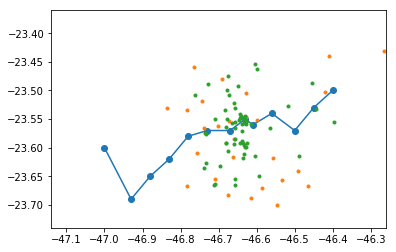

In [521]:
a = gogo(x_i, y_i, x_f, y_f, plot=True, normal=False, N_points=N_points)

In [467]:
np.max(a)

-23.359999999999943

In [519]:
c = [[1, 2], [3, 4]]
a = []
for i in c:
    b = []
    for j in i:
        b.append(j)
    a.append(b)

In [520]:
a

[[1, 2], [3, 4]]

array([-46.4 , -46.45, -46.5 , -46.56, -46.61, -46.63, -46.67, -46.73,
       -46.78, -46.83, -46.88, -46.93, -47.  ])